In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
sns.set_style('darkgrid')

In [ ]:
def define_paths(directory):
    filepaths = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for file in os.listdir(label_path):
                filepaths.append(os.path.join(label_path, file))
                labels.append(label)
    return filepaths, labels



In [ ]:
def define_df(files, classes):
  Fseries = pd.Series(files, name='filepaths')
  Cseries = pd.Series(classes, name='classes')
  df = pd.concat([Fseries, Cseries], axis=1)
  return df

In [ ]:
def create_df(train_dir,val_dir,test_dir):
  train_paths, train_labels = define_paths(train_dir)
  val_paths, val_labels = define_paths(val_dir)
  test_paths, test_labels = define_paths(test_dir)
  print("Train Paths:", train_paths[:5], " Labels:", train_labels[:5])
  print("Val Paths:", val_paths[:5], " Labels:", val_labels[:5])
  print("Test Paths:", test_paths[:5], " Labels:", test_labels[:5])
  train_df = pd.DataFrame({'filepaths': train_paths, 'labels': train_labels})  # Changed 'Labels' to 'labels'
  val_df = pd.DataFrame({'filepaths': val_paths, 'labels': val_labels})
  test_df = pd.DataFrame({'filepaths': test_paths, 'labels': test_labels})
  print(train_df.head())
  return train_df, val_df, test_df


In [ ]:
def create_gens(train_df, val_df, test_df, batch_size):
  img_size = (224,224)
  tr_gen = ImageDataGenerator(rescale = 1./255 , horizontal_flip = True)
  ts_gen = ImageDataGenerator(rescale = 1./255)
  train_gen = tr_gen.flow_from_dataframe(
      train_df, x_col = 'filepaths', y_col = 'labels',
      target_size = img_size, class_mode = 'categorical', shuffle = True,
      batch_size = batch_size )
  valid_gen = ts_gen.flow_from_dataframe(
      val_df, x_col = 'filepaths', y_col = 'labels',
      target_size = img_size, class_mode = 'categorical', shuffle = True,
      batch_size = batch_size )
  test_gen = ts_gen.flow_from_dataframe(
      test_df, x_col = 'filepaths', y_col = 'labels',
      target_size = img_size, class_mode = 'categorical', shuffle = False,
      batch_size = batch_size )
  return train_gen, valid_gen, test_gen

In [ ]:
!ls '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image'

CnnCTImage94.h5  CnnCTImage97.h5  Test	Train  Validation


In [ ]:
train_dir = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train'
val_dir = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Validation'
test_dir = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Test'

In [ ]:
train_df, valid_df, test_df = create_df(train_dir, val_dir, test_dir)

Train Paths: ['/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train/hemorrhagic/87 (9).jpg', '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train/hemorrhagic/68 (1).jpg', '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train/hemorrhagic/66 (15).jpg', '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train/hemorrhagic/87 (33).jpg', '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train/hemorrhagic/79 (6).jpg']  Labels: ['hemorrhagic', 'hemorrhagic', 'hemorrhagic', 'hemorrhagic', 'hemorrhagic']
Val Paths: ['/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Validation/hemorrhagic/66 (21) - Copy.jpg', '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Validation/hemorrhagic/70 (15).jpg', '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Validation/hemorrhagic/71 (34).jpg', '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Validation/hemorrhagic/94 (35).jpg', '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Validation/hemorrhagic/66 (9) - Copy.jpg']  Labels: ['hemorrhagic',

In [ ]:
train_paths, train_labels = define_paths(train_dir)

In [ ]:
print(train_paths[:5], train_labels[:5])

['/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train/hemorrhagic/87 (9).jpg', '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train/hemorrhagic/68 (1).jpg', '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train/hemorrhagic/66 (15).jpg', '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train/hemorrhagic/87 (33).jpg', '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train/hemorrhagic/79 (6).jpg'] ['hemorrhagic', 'hemorrhagic', 'hemorrhagic', 'hemorrhagic', 'hemorrhagic']


In [ ]:
print (train_df.columns)

Index(['filepaths', 'labels'], dtype='object')


In [ ]:
batch_size = 32
train_gen, valid_gen, test_gen = create_gens (train_df, valid_df, test_df, batch_size)

Found 1843 validated image filenames belonging to 2 classes.
Found 235 validated image filenames belonging to 2 classes.
Found 437 validated image filenames belonging to 2 classes.


In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

In [ ]:
model = Sequential([
  Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
  MaxPooling2D((2, 2)),
  BatchNormalization(),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D( (2, 2)),
  BatchNormalization(),
  Flatten ( ),
  Dense (128,activation='relu'),
  Dropout (0.5),
  Dense(len (train_gen.class_indices), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history= model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    verbose=1
    )

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.8322 - loss: 0.2728 - val_accuracy: 0.9234 - val_loss: 0.1590
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.8623 - loss: 0.2465 - val_accuracy: 0.9021 - val_loss: 0.2709
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.8673 - loss: 0.2320 - val_accuracy: 0.9021 - val_loss: 0.2046
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - accuracy: 0.8902 - loss: 0.2064 - val_accuracy: 0.9234 - val_loss: 0.1704
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - accuracy: 0.8843 - loss: 0.2071 - val_accuracy: 0.9106 - val_loss: 0.1907
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.8970 - loss: 0.1962 - val_accuracy: 0.9362 - val_loss: 0.1673
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.8746 - loss: 0.2114 - val_accuracy: 0.9021 - val_loss: 0.2555
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.8665 - loss: 0.2325 - val_accu

In [ ]:
loss,accuracy = model.evaluate(test_gen)
print(f'Test Accuracy: {round(accuracy*100,2)}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 333s 26s/step - accuracy: 0.9039 - loss: 0.2423
Test Accuracy: 94.05


In [ ]:
test_gen.reset()
y_pred = np.argmax(model.predict(test_gen), axis=-1)
y_true = test_gen.classes
labels = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=labels))
cm = confusion_matrix(y_true, y_pred)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step
              precision    recall  f1-score   support

 hemorrhagic       0.93      0.86      0.90       130
   ischaemic       0.94      0.97      0.96       307

    accuracy                           0.94       437
   macro avg       0.94      0.92      0.93       437
weighted avg       0.94      0.94      0.94       437



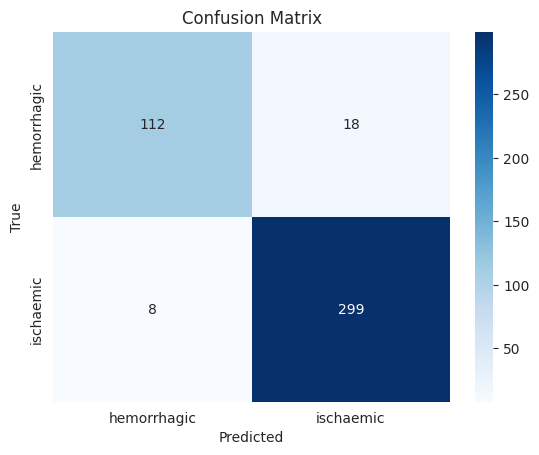

In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_name = 'CnnCTImage94'
model.save(f'/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/{model_name}.h5')

In [ ]:
def plot_training_with_test(hist, test_loss=None, test_acc=None):
    # Extract training and validation metrics
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    # Determine the best epochs for loss and accuracy
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    # Prepare data for plotting
    Epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'best epoch (loss) = {str(index_loss + 1)}'
    acc_label = f'best epoch (accuracy) = {str(index_acc + 1)}'

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    # Plot Loss vs Epochs
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
    if test_loss is not None:
        plt.axhline(y=test_loss, color='blue', linestyle='--', label=f'Test Loss = {test_loss:.4f}')
    plt.scatter(index_loss + 1, val_loss[index_loss], s=150, c='blue', label=loss_label)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()

    # Plot Accuracy vs Epochs
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    if test_acc is not None:
        plt.axhline(y=test_acc, color='blue', linestyle='--', label=f'Test Accuracy = {test_acc:.4f}')
    plt.scatter(index_acc + 1, val_acc[index_acc], s=150, c='blue', label=acc_label)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


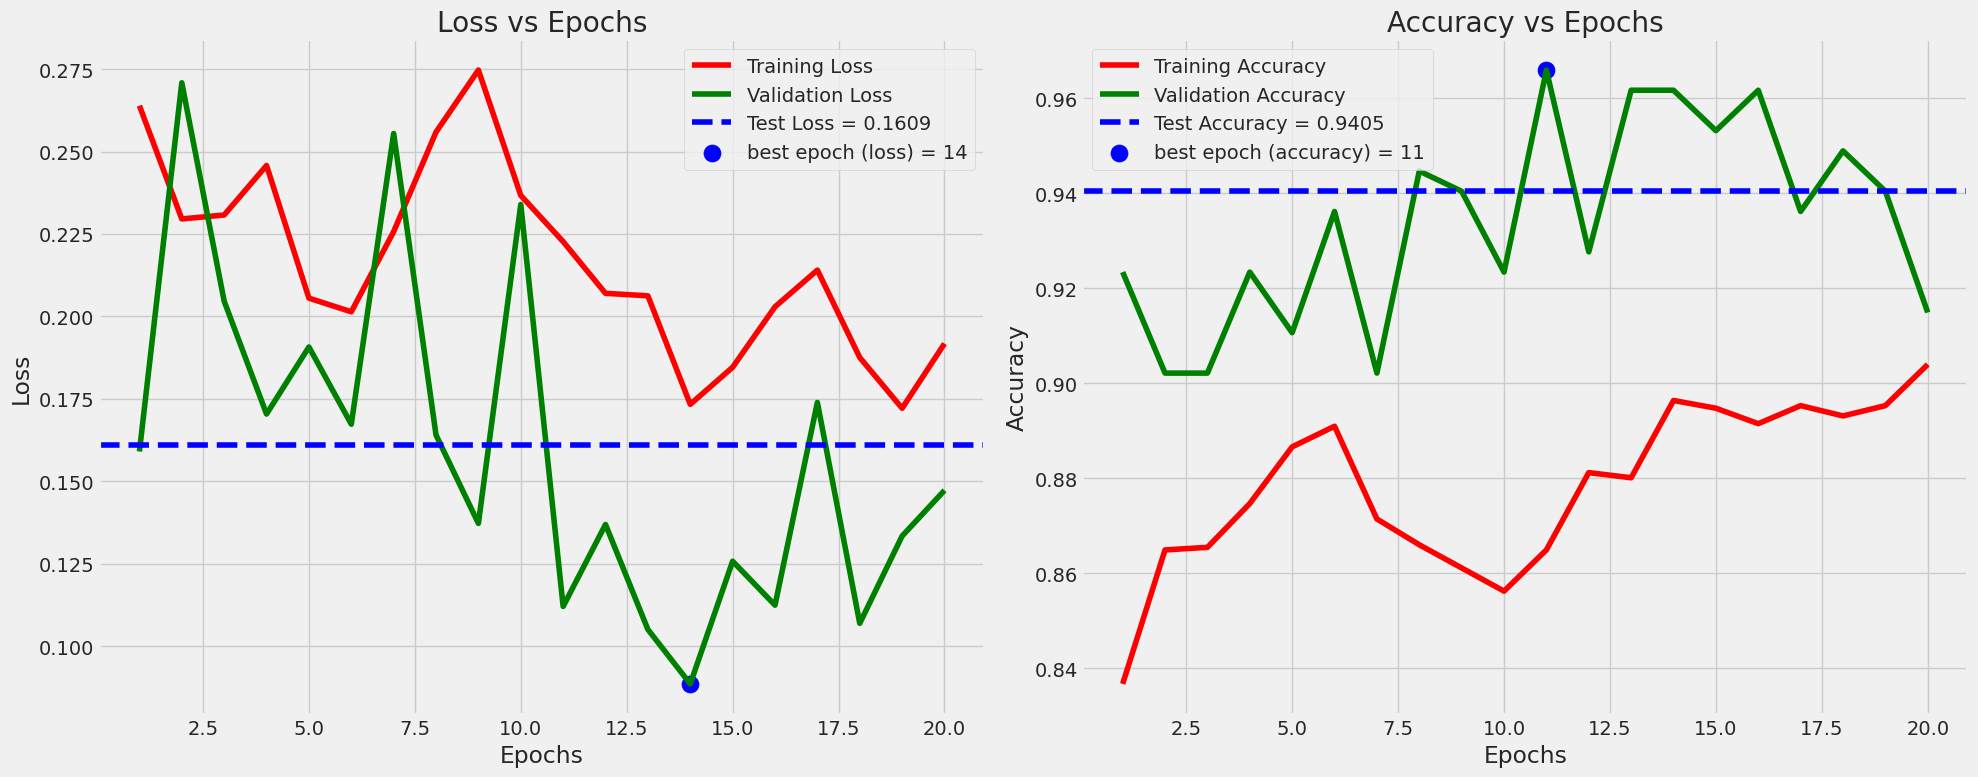

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_gen, verbose=0)

# Plot the training and validation performance along with test metrics
plot_training_with_test(history, test_loss=test_loss, test_acc=test_acc)


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adamax

In [ ]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling="max"
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256,
          kernel_regularizer=regularizers.l2(0.016),
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006),
          activation='relu'),
    Dropout(rate=0.45, seed=123),
    Dense(class_count, activation='softmax')
])


In [ ]:
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,383,141 (16.72 MB)

 Trainable params: 4,338,558 (16.55 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    verbose=1
)

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 128s 982ms/step - accuracy: 0.4986 - loss: 10.6754 - val_accuracy: 0.6638 - val_loss: 7.2790
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 68s 220ms/step - accuracy: 0.6029 - loss: 7.0671 - val_accuracy: 0.6723 - val_loss: 7.1227
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 211ms/step - accuracy: 0.6025 - loss: 6.6938 - val_accuracy: 0.6681 - val_loss: 6.9813
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 216ms/step - accuracy: 0.5996 - loss: 6.2647 - val_accuracy: 0.6681 - val_loss: 6.2214
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 216ms/step - accuracy: 0.5960 - loss: 5.9111 - val_accuracy: 0.6681 - val_loss: 6.3616
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 233ms/step - accuracy: 0.5900 - loss: 5.5525 - val_accuracy: 0.6681 - val_loss: 5.6681
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 217ms/step - accuracy: 0.5939 - loss: 5.1921 - val_accuracy: 0.6681 - val_loss: 5.1041
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - accuracy: 0.5713 - loss: 4.8541 - val_ac

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy



In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
train_gen = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(128, 128),
    class_mode='binary',  # Binary mode
    batch_size=batch_size,
    shuffle=True
)
valid_gen = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(128, 128),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True
)
test_gen = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(128, 128),
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)


Found 1843 validated image filenames belonging to 2 classes.
Found 235 validated image filenames belonging to 2 classes.
Found 437 validated image filenames belonging to 2 classes.


In [ ]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20,
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


58/58 ━━━━━━━━━━━━━━━━━━━━ 22s 272ms/step - accuracy: 0.5853 - loss: 0.6831 - val_accuracy: 0.7702 - val_loss: 0.5274
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.8092 - loss: 0.4366 - val_accuracy: 0.7532 - val_loss: 0.5170
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.8851 - loss: 0.2694 - val_accuracy: 0.9106 - val_loss: 0.1895
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - accuracy: 0.9543 - loss: 0.1196 - val_accuracy: 0.9447 - val_loss: 0.1254
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - accuracy: 0.9788 - loss: 0.0676 - val_accuracy: 0.9489 - val_loss: 0.1016
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.9904 - loss: 0.0302 - val_accuracy: 0.9447 - val_loss: 0.1282
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - accuracy: 0.9797 - loss: 0.0499 - val_accuracy: 0.9702 - val_loss: 0.0908
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step - accuracy: 0.9914 - loss: 0.0226 - val_accuracy: 0.978

In [ ]:
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f'Test Accuracy: {round(test_acc * 100, 2)}%')


Test Accuracy: 97.48%


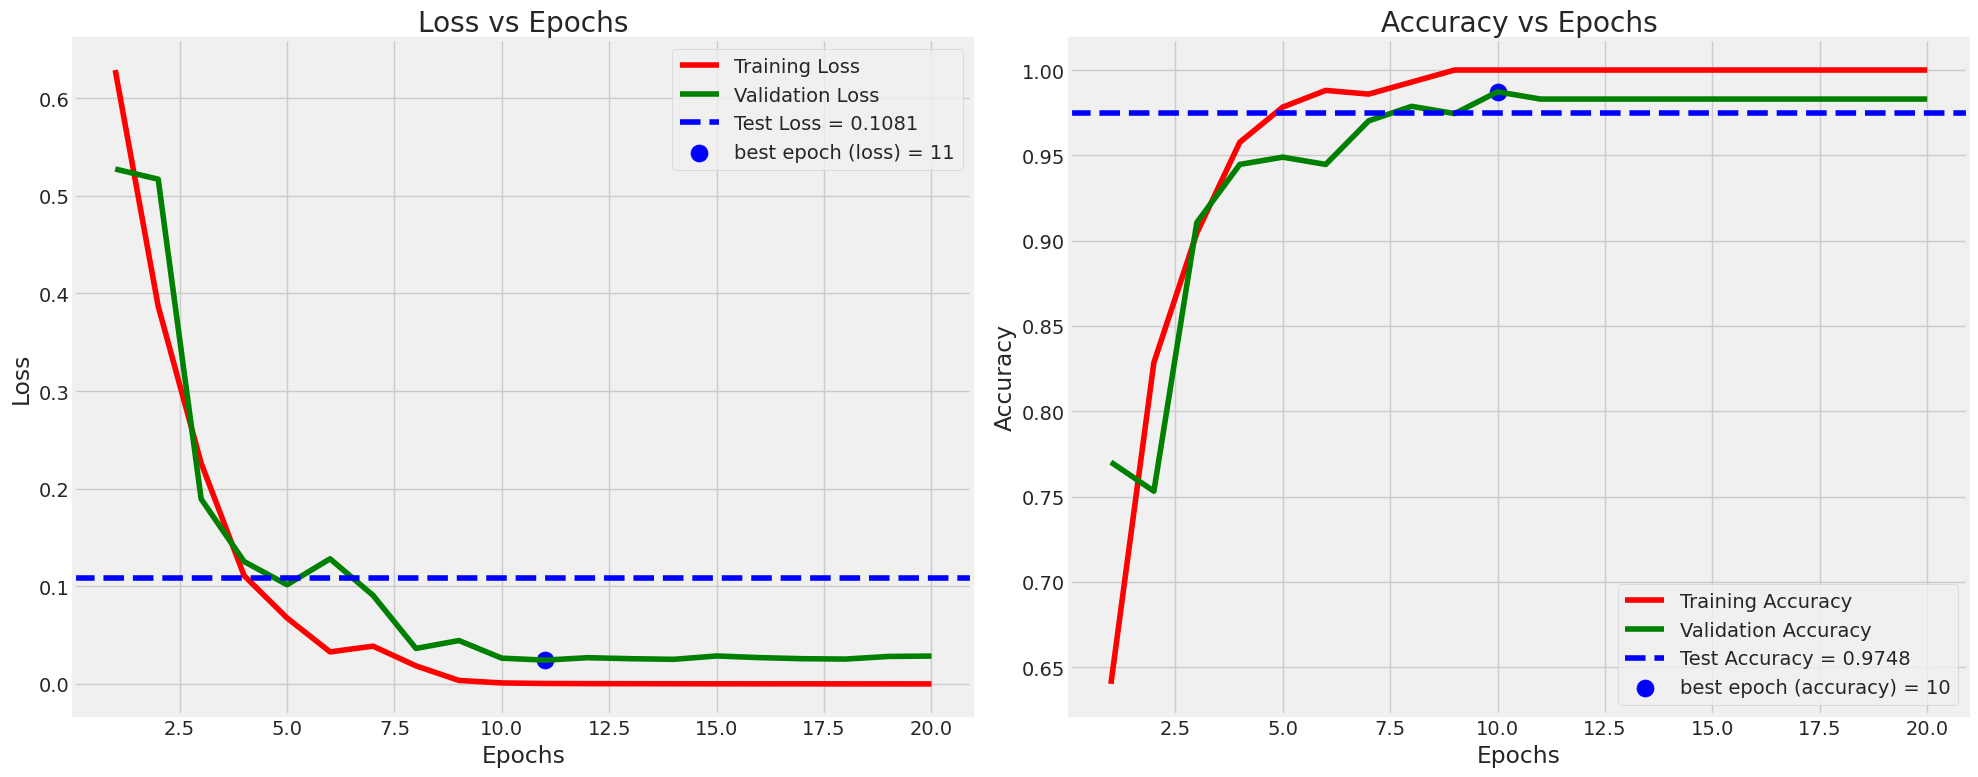

In [ ]:
plot_training_with_test(history, test_loss=test_loss, test_acc=test_acc)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step
              precision    recall  f1-score   support

 Hemorrhagic       0.92      1.00      0.96       130
    Ischemic       1.00      0.96      0.98       307

    accuracy                           0.97       437
   macro avg       0.96      0.98      0.97       437
weighted avg       0.98      0.97      0.98       437



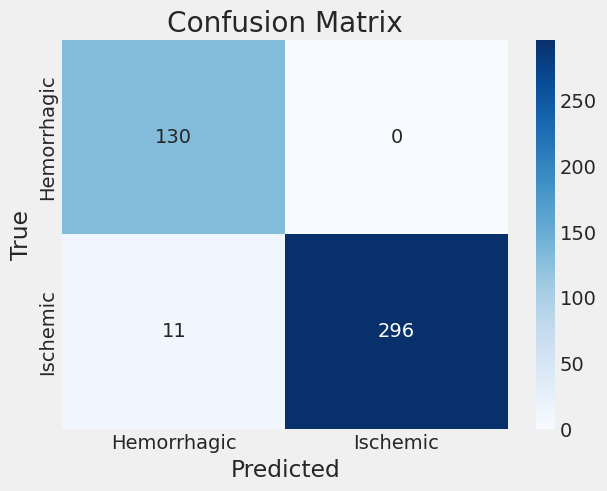

In [ ]:
# Generate predictions and evaluate performance
test_gen.reset()
y_pred = (model.predict(test_gen) > 0.5).astype("int32").flatten()  # Convert sigmoid outputs to binary
y_true = test_gen.classes

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=['Hemorrhagic', 'Ischemic']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with new labels
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Hemorrhagic', 'Ischemic'], yticklabels=['Hemorrhagic', 'Ischemic'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model_name = 'CnnCTImage97'
model.save(f'/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/{model_name}.h5')